# Building a `ws3` model from scratch

This notebook has an example of building a new `ws3` model from scratch.

> We _strongly recommend_ that you run this notebook in venv-sandboxed Python kernel (see `venv_python_kernel_setup` notebook for an example of how to do this). This will ensure that you are working from a fresh Python package environment, and not wasting time debugging random interactions between this notebook and whatever mishmash of packages you have installed on your system in various parts of your Python path. You have been warned. 

## Configure modelling environment

In [1]:
%load_ext autoreload
%autoreload 2

Optionally, uninstall the `ws3` package and replace it with a pointer to _this local clone of the GitHub repository code_ (useful if you want ot tweak the source code for whatever reason). 

In [2]:
clobber_ws3 = True
if clobber_ws3:
    %pip uninstall -y ws3
    %pip install -e ..

Found existing installation: ws3 1.0.0
Uninstalling ws3-1.0.0:
  Successfully uninstalled ws3-1.0.0
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///home/gep/projects/ws3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ws3 (pyproject.toml) ... done
  Created wheel for ws3: filename=ws3-1.0.0-py2.py3-none-any.whl size=1736 sha256=1f1860ee50db5aaaad66016eaaea54446e29e9452c32e0a64dbda36603634601
  Stored in directory: /tmp/pip-ephem-wheel-cache-lsywbfzc/wheels/8a/d1/f0/2b533a60b366fa03a12ca91a1ad068761e66b9df68fa0cadb9
Successfully built ws3
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core

## Set up Python environment

Define some basic parameters.

In [4]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
tvy_name = 'totvol'

Import sample inventory and yield curve data.

The inventory data is imported a from vector data layer (stored in industry-standard ESRI Shapefile format). This is a small square of real forest data clipped from a larger dataset representing Timber Supply Area (TSA) 24 in British Columbia (BC), Canada. This data layer is derived from publicly-available BC Vegetation Resource Inventory (VRI) datasets (see [British Columbia Data Catalogue](https://catalogue.data.gov.bc.ca/)) that we pre-processed to include the data attributes we need (in the format we want) for this `ws3` model-building example. 

The yield curve data was generated from a complex process (the details of which are outside the scope of this example, contact [Gregory Paradis](mailto:gregory.paradis@ubc.ca) for details), using a methodology consistent with _de facto_ professional best-practices for the Timber Supply Review (TSR) modelling process in BC. 

In [5]:
stands = gpd.read_file('data/shp/tsa24_clipped.shp/stands.shp')

In [6]:
stands

,theme0,theme1,theme2,curve1,curve2,SPECIES_CD,age,area,theme3,geometry
0,tsa24_clipped,1,2401002,2401002,2401002,PLI,145,0.111814,204,"MULTIPOLYGON (((1112711.004 1120816.405, 11127..."
1,tsa24_clipped,1,2401002,2401002,2401002,PLI,145,0.113925,204,"POLYGON ((1113299.5 1120834.77, 1113298.336 11..."
2,tsa24_clipped,1,2401002,2401002,2401002,PLI,135,7.025088,204,"POLYGON ((1112035.066 1121064.403, 1112071.399..."
3,tsa24_clipped,1,2402002,2402002,2402002,PLI,93,11.029940,204,"POLYGON ((1114394.74 1120822.943, 1114394.421 ..."
4,tsa24_clipped,1,2401000,2401000,2401000,SX,145,9.581284,100,"MULTIPOLYGON (((1114322.804 1120983.973, 11143..."
...,...,...,...,...,...,...,...,...,...,...
185,tsa24_clipped,1,2401002,2401002,2401002,PLI,85,5.667730,204,"POLYGON ((1115036.356 1124809.762, 1115037.888..."
186,tsa24_clipped,1,2401002,2401002,2401002,PLI,85,1.811041,204,"POLYGON ((1114157.65 1124633.924, 1114154.478 ..."
187,tsa24_clipped,1,2401002,2401002,2401002,PLI,95,1.137586,204,"POLYGON ((1114675.233 1124802.103, 1114684.36 ..."
188,tsa24_clipped,0,2401000,2401000,2401000,SB,95,0.494253,100,"POLYGON ((1114249.328 1124669.031, 1114271.225..."


Import data tables linking analysis units to yield curves.

In [7]:
au_table = pd.read_csv('data/au_table.csv').set_index('au_id')
curve_table = pd.read_csv('data/curve_table.csv')
curve_points_table = pd.read_csv('data/curve_points_table.csv').set_index('curve_id')

In [8]:
au_table['thlb'] = au_table.apply(lambda row: 0 if row.unmanaged_curve_id == row.managed_curve_id else 1, axis=1)

In [9]:
au_table

,record_id,tsa,stratum_code,si_level,canfi_species,unmanaged_curve_id,managed_curve_id,thlb
au_id,,,,,,,,
2401000,63,24,SBS_SX,L,100,2401000,2401000,0
2402000,64,24,SBS_SX,M,100,2402000,2422000,1
2403000,65,24,SBS_SX,H,100,2403000,2423000,1
2401001,66,24,ESSF_BL,L,304,2401001,2401001,0
2402001,67,24,ESSF_BL,M,304,2402001,2402001,0
2403001,68,24,ESSF_BL,H,304,2403001,2423001,1
2401002,69,24,SBS_PLI,L,204,2401002,2421002,1
2402002,70,24,SBS_PLI,M,204,2402002,2422002,1
2403002,71,24,SBS_PLI,H,204,2403002,2423002,1


Need to rebuild the Timber Harvesting Land Base (THLB) attribute (i.e., `theme1`) in the stand inventory table. Current implementation is inconsistent with yield VDYP/TIPSY yield curve (and AU definition) modelling assumptions. 

In a nutshell, AUs either have only a VDYP yield curve or both VDYP and TISPY yield curves (if considered potentially operable). We need to set the THLB attribute to 0 for stands in AUs with have only a VDYP curve (i.e., where `au_table.unmanaged_curve_id == au_table.managed_curve_id`), and 1 otherwise. 

Otherwise, we would get weird cases where we can harvest a stand but there is not TIPSY curve defined for second-growth stand conditions.

In [10]:
stands.theme1 = stands.apply(lambda row: au_table.loc[row.theme2].thlb, axis=1)

Copy `curve1` to `theme4` so we can track yield curve transitions independently from AU.

In [11]:
stands['theme4'] = stands.curve1

Set up themes.

In [12]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AU
            'theme3', # leading species code
            'theme4'] # yield curve ID
basecodes = [list(map(lambda x: str(x), stands[tc].unique())) for tc in theme_cols]

In [13]:
# also scrape au_table for AU and curve ID values that are not in inventory but might pop up later (hack?)
basecodes[2] = list(set(basecodes[2] + list(au_table.index.astype(str))))
basecodes[3] = list(set(basecodes[3] + list(au_table.canfi_species.astype(str))))
basecodes[4] = list(set(basecodes[4] + list(au_table.unmanaged_curve_id.astype(str)) + list(au_table.managed_curve_id.astype(str))))               

In [14]:
basecodes

[['tsa24_clipped'],
 ['1', '0'],
 ['2403004',
  '2402004',
  '2401006',
  '2403002',
  '2402002',
  '2401004',
  '2402001',
  '2402000',
  '2403001',
  '2402003',
  '2403007',
  '2403000',
  '2401002',
  '2401005',
  '2402005',
  '2403003',
  '2401000',
  '2401003',
  '2402006',
  '2402007',
  '2401001',
  '2403005',
  '2403006',
  '2401007'],
 ['304', '100', '204', '1201', '104'],
 ['2422003',
  '2403004',
  '2402004',
  '2401006',
  '2422002',
  '2423003',
  '2403002',
  '2422007',
  '2423001',
  '2423000',
  '2402002',
  '2401004',
  '2402001',
  '2421007',
  '2423007',
  '2402000',
  '2403001',
  '2423002',
  '2422000',
  '2402003',
  '2423004',
  '2403007',
  '2401002',
  '2403000',
  '2401005',
  '2402005',
  '2421002',
  '2403003',
  '2401000',
  '2401003',
  '2402006',
  '2402007',
  '2401001',
  '2403005',
  '2403006',
  '2422004',
  '2401007']]

Create a new blank `ForestModel` instance.

In [15]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

Now populate `fm` with data.

Set up themes.

In [16]:
for ti, t in enumerate(theme_cols):
    fm.add_theme(t, basecodes[ti])

Load areas from inventory data.

In [17]:
gstands = stands.groupby(theme_cols+['age'])

In [18]:
for name, group in gstands:
    dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
    if dtk not in fm.dtypes:
        fm.dtypes[dtk] = ws3.forest.DevelopmentType(dtk, fm)
    fm.dtypes[dtk].area(0, age, area)

Inspect `dtypes` attribute of `ForestModel` instance.

Directly inject yield curve data into the `fm` instance. 

This a bit obscure, and the exact process will differ from case to case depending on input data structure and desired model structure. This is _not_ the one and only way to do this.

In [19]:
for au_id, au_row in au_table.iterrows():
    yname = 's%04d' % int(au_row.canfi_species)
    for is_managed in (0, 1):
        curve_id = au_row.unmanaged_curve_id if not is_managed else au_row.managed_curve_id
        mask = ('?', '?', str(au_id), '?', str(curve_id))
        points = [(r.x, r.y) for _, r in curve_points_table.loc[curve_id].iterrows() if not r.x % period_length and r.x <= max_age]
        c = fm.register_curve(ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=fm.max_age, period_length=period_length))
        fm.yields.append((mask, 'a', [(yname, c)])) # only if not already present?
        fm.ynames.add(yname) 
        for dtk in fm.unmask(mask): 
            fm.dtypes[dtk].add_ycomp('a', yname, c)

Add total volume curves.

In [20]:
expr = '_SUM(%s)' % ', '.join(fm.ynames)
fm.yields.append((('?', '?', '?', '?', '?'), 'c', [(tvy_name, expr)]))
fm.ynames.add(tvy_name)
for dtk in fm.dtypes.keys(): fm.dtypes[dtk].add_ycomp('c', tvy_name, expr)  

Set up actions. This part is a bit ugly, because `ws3` was originally designed to import Woodstock code (not to directly code models like this). As with yield curves, there is more than one way to implement this, and the details will depend on your input data format and exactly what model you are trying to build.

All of this gets automatically set up correctly if you use the built-in functions to import Woostock-style input files, but is your responsibility if you bypass and direct-code your model.

There is a lot going on here. 

Generic transitions are configured at the `ForestModel` level. These are basically equivalent (conceptually, and functionally) to transitions defined in a Woodstock model. The source masks allow `ws3` to match the key of a new development type (whose runtime instantiation is triggered by application of an action) to one or more appropriate transitions, which then get compiled into the new development type. Etc. Makes more sense if you understand how Woodstock models work. Need to provide more information about this in the `ws3` documentation.

In [21]:
acode = 'harvest'
oe = '_age >= 80 and _age <= 500' # operability expression
fm.transitions[acode] = {}
for au_id, au_row in au_table.iterrows():
    if not au_row.thlb: continue
    target_curve_id = au_row.managed_curve_id
    smask = ('?', '?', str(au_id), '?', '?')
    tmask = ('?', '?', '?', '?', str(target_curve_id))
    target = [(tmask, 1.0, None, None, None, None, None)] # list of one (single target... not modelling "divergent" transitions)
    fm.actions[acode] = ws3.forest.Action(acode, targetage=0, is_harvest=True)
    fm.oper_expr[acode] = {smask:oe}        
    fm.transitions[acode].update({smask:{'':target}}) # the '' is a blank source condition expression
    for dtk in fm.unmask(smask):
        dt = fm.dtypes[dtk]
        dt.oper_expr[acode] = [oe]
        for age in range(1, fm.max_age):
            if not dt.is_operable(acode, 1, age): continue
            #if dtk == ('tsa24_clipped', '1', '2402000', '100', '2402000'):
            #    print('setting transition for', dtk, age, 'to', target)
            fm.dtypes[dtk].transitions[acode, age] = target

In [22]:
fm.compile_actions()

## Poke around `ForestModel` instance data structures to see what we just did

We can poke around the model data structures a bit to see the data we injected above.

Print list of yield component names we are using in this model. In our case, the `sXXX` curves are species-specific yield curves where `XXX` is a [CANFI](https://nfi.nfis.org/en/history) tree species code.

In [23]:
fm.ynames

{'s0100', 's0104', 's0204', 's0304', 's1201', 'totvol'}

List yield components present in our example `DevelopmentType` instance from earlier.

In [24]:
dt.ycomps()

['s0204', 'totvol']

Get a reference to the total yield curve.

The `ws3.core.Curve` class can do all sorts of neat things with yield curve (e.g., curves can resample themselves, interpolate between data points, extrapolate beyond data points, be operated on using standard Python arithmetic operators, CAI, MAI, YTP, etc.). See source code for details. 

In [25]:
c = dt.ycomp('totvol')

In [26]:
c.points()

[(0, 0.0),
 (30, 0.2),
 (40, 24.4),
 (50, 98.20000000000002),
 (60, 184.10000000000002),
 (70, 257.4),
 (80, 312.6),
 (90, 353.8),
 (100, 380.3),
 (110, 400.5),
 (120, 413.0),
 (130, 422.1),
 (140, 428.7),
 (150, 433.3),
 (160, 435.0),
 (180, 437.4),
 (190, 436.8),
 (200, 434.7),
 (210, 433.0),
 (230, 430.5),
 (250, 428.9),
 (1000, 426.9)]

Plot total volume, CAI, MAI, MAI YTP, etc. Optimal rotation age in red.

Note that all the stuff a forester would expect to see happening with these yield curves is seems to be happening:
* A tangent to the volume curve passing through the origin touches the yield curve at the optimal rotation age.
* The CAI curve is blocky because curve points are sparse (curves have been automatically resampled to 10-year intervals by default, so the yield curve is actually a piecewise linear assemblage).
* The MAI curve intersects the CAI curve at the optimal rotation age.

This is not meant to be an exhaustive demonstration of `ws3` curve manipulation and usage. Go have a look at the source code to see what else you can do. The `Curve` class implementation is intended to help avoid needing to so low-level math and logic on curve datasets for most typical model-building use cases.

(0.0, 300.0)

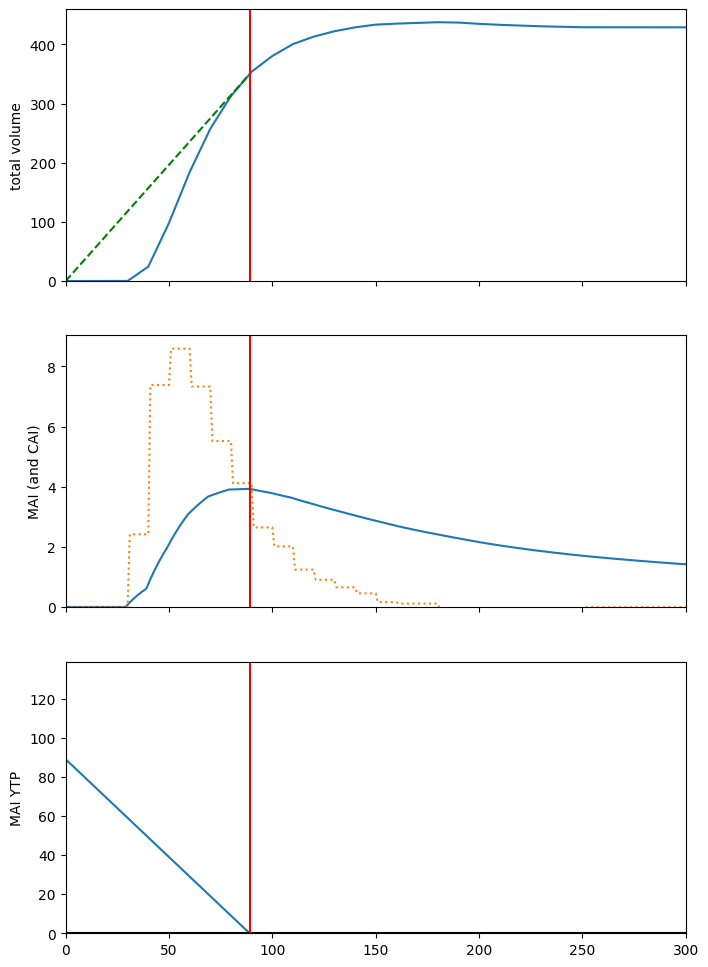

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 300)

Note that when setting up a new `ForestModel` instance, you have to stash a copy of _all_ the yield curves you need, _including the curves for development types that are not present in the intial inventory_ (`ws3` grabs a copy of these when JIt-building new `DevelopmentType` objects on the fly, only if induced by applying an action to an development type and the specified transition induces a new development type). 

All of this gets automatically set up correctly if you use the built-in functions to import Woostock-style input files, but is your responsibility if you bypass and direct-code your model.

In [28]:
len(fm.yields), fm.yields[0]

(49,
 (('?', '?', '2401000', '?', '2401000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7d3aa21bfe30>)]))

Have a look at the actions in the model.

In [29]:
fm.actions

{'harvest': <ws3.forest.Action at 0x7d3a9cd36f30>}

In [30]:
list(fm.transitions['harvest'].items())[:3]

[(('?', '?', '2402000', '?', '?'),
  {'': [(('?', '?', '?', '?', '2422000'),
     1.0,
     None,
     None,
     None,
     None,
     None)]}),
 (('?', '?', '2403000', '?', '?'),
  {'': [(('?', '?', '?', '?', '2423000'),
     1.0,
     None,
     None,
     None,
     None,
     None)]}),
 (('?', '?', '2403001', '?', '?'),
  {'': [(('?', '?', '?', '?', '2423001'),
     1.0,
     None,
     None,
     None,
     None,
     None)]})]

In [31]:
dt.oper_expr

defaultdict(list, {'harvest': ['_age >= 80 and _age <= 500']})

In [32]:
dt.operability

{'harvest': {1: (80, 500),
  2: (80, 500),
  3: (80, 500),
  4: (80, 500),
  5: (80, 500),
  6: (80, 500),
  7: (80, 500),
  8: (80, 500),
  9: (80, 500),
  10: (80, 500)}}

In [33]:
list(dt.transitions.items())[:3]

[(('harvest', 80),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)]),
 (('harvest', 81),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)]),
 (('harvest', 82),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)])]

In [34]:
list(dt.transitions.items())[-3:]

[(('harvest', 498),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)]),
 (('harvest', 499),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)]),
 (('harvest', 500),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)])]

In [35]:
fm.dtypes

{('tsa24_clipped',
  '0',
  '2401000',
  '100',
  '2401000'): <ws3.forest.DevelopmentType at 0x7d3aa21f2a20>,
 ('tsa24_clipped',
  '0',
  '2402005',
  '1201',
  '2402005'): <ws3.forest.DevelopmentType at 0x7d3aa21f19a0>,
 ('tsa24_clipped',
  '1',
  '2401002',
  '204',
  '2401002'): <ws3.forest.DevelopmentType at 0x7d3aa21f2c00>,
 ('tsa24_clipped',
  '1',
  '2401002',
  '204',
  '2421002'): <ws3.forest.DevelopmentType at 0x7d3aa21f2870>,
 ('tsa24_clipped',
  '1',
  '2402000',
  '100',
  '2402000'): <ws3.forest.DevelopmentType at 0x7d3aa21f2d50>,
 ('tsa24_clipped',
  '1',
  '2402002',
  '204',
  '2402002'): <ws3.forest.DevelopmentType at 0x7d3aa21f2ea0>,
 ('tsa24_clipped',
  '1',
  '2403000',
  '100',
  '2403000'): <ws3.forest.DevelopmentType at 0x7d3aa21f2ed0>,
 ('tsa24_clipped',
  '1',
  '2403002',
  '204',
  '2403002'): <ws3.forest.DevelopmentType at 0x7d3aa21f3080>,
 ('tsa24_clipped',
  '1',
  '2403002',
  '204',
  '2423002'): <ws3.forest.DevelopmentType at 0x7d3aa21f3170>}

Get a reference to one of the managed (i.e., THLB) `DevelopmentType` instances we now have in `fm` (specifically, the `DevelopmentType` with key `('tsa24_clipped', '1', '2403002', '204', '2423002')`. We do this by _unmasking_ the `DevelopmentType` list using a mask string in Woodstock format, where the `?` represents a wildcard. Refer to the `ws3` documentation for a more in-depth explanation of theme and masks and development types and such (this documentation is a WIP so this may not be clearly documented yet). 

In [36]:
dtk = fm.unmask('? 1 ? ? ?').pop()
dtk

('tsa24_clipped', '1', '2403002', '204', '2423002')

In [37]:
dt = fm.dtypes[dtk]
dt.key

('tsa24_clipped', '1', '2403002', '204', '2423002')

Inspect the `_areas` private attribute of the `DevelopmentType` instance we grabbed. This data structure stores the _inventory_ for the parent `DevelopmentType` (i.e., area by period and ageclass). 

At this point in the modelling process, we have only defined the _initial inventory_ in period 0. The other periods get populated later when we initialize the period-1 inventory and simulated growth and actions (which we have not done yet).

In [38]:
dt._areas

{0: defaultdict(float, {9: 59.81429119367274, 18: 32.366198551219505}),
 1: defaultdict(float, {}),
 2: defaultdict(float, {}),
 3: defaultdict(float, {}),
 4: defaultdict(float, {}),
 5: defaultdict(float, {}),
 6: defaultdict(float, {}),
 7: defaultdict(float, {}),
 8: defaultdict(float, {}),
 9: defaultdict(float, {}),
 10: defaultdict(float, {})}

You can see that initial inventory for this `DevelopementType` contains 59.8 hectares in ageclass 9 and 32.4 hectares in ageclass 18). 

Below, we should how you can access this same information using the public interfaces built into the `DevelopmentType` and `ForestModel` classes.

In [39]:
dt.area(period=0) # total inventory area in period 0

92.18048974489224

In [40]:
acd = fm.age_class_distribution(0, mask=dt.key, omit_null=True)
acd

{9: 59.81429119367274, 18: 32.366198551219505}

In [41]:
for age in acd:
    print(age, dt.area(period=0, age=age)) # ageclass 9 inventory area in period 0

9 59.81429119367274
18 32.366198551219505


## Implement a priority queue harvest scheduling heuristic

Below we define a function that implements a old-stand-first priority queue harvest scheduling heuristic. To make this demo as n00b friends as possible, we set this up to be self-parametrising, i.e., the model automatically figures out an appropriate "periodic harvest area target" parameter value, by analysing the shape of its own yield curves to estimate a landscape-level optimal rotation age.

In [42]:
def schedule_harvest_areacontrol(fm, period=None, acode='harvest', util=0.85, 
                                 target_masks=None, target_areas=None,
                                 target_scalefactors=None,
                                 mask_area_thresh=0.,
                                 verbose=0):
    if not target_areas:
        if not target_masks: # default to AU-wise THLB 
            au_vals = []
            au_agg = []
            for au in fm.theme_basecodes(2):
                mask = '? 1 %s ? ?' % au
                masked_area = fm.inventory(0, mask=mask)
                if masked_area > mask_area_thresh:
                    au_vals.append(au)
                else:
                    au_agg.append(au)
                    if verbose > 0:
                        print('adding to au_agg', mask, masked_area)
            if au_agg:
                fm._themes[2]['areacontrol_au_agg'] = au_agg 
                if fm.inventory(0, mask='? ? areacontrol_au_agg ? ?') > mask_area_thresh:
                    au_vals.append('areacontrol_au_agg')
            target_masks = ['? 1 %s ? ?' % au for au in au_vals]
        target_areas = []
        for i, mask in enumerate(target_masks): # compute area-weighted mean CMAI age for each masked DT set
            masked_area = fm.inventory(0, mask=mask, verbose=verbose)
            if not masked_area: continue
            r = sum((fm.dtypes[dtk].ycomp('totvol').mai().ytp().lookup(0) * fm.dtypes[dtk].area(0)) for dtk in fm.unmask(mask))
            r /= masked_area
            asf = 1. if not target_scalefactors else target_scalefactors[i]  
            ta = (1/r) * fm.period_length * masked_area * asf
            #print(mask, masked_area, r, asf, ta)
            target_areas.append(ta)
    periods = fm.periods if not period else [period]
    for period in periods:
        for mask, target_area in zip(target_masks, target_areas):
            if verbose > 0:
                print('calling areaselector', period, acode, target_area, mask)
            fm.areaselector.operate(period, acode, target_area, mask=mask, verbose=verbose)
    sch = fm.compile_schedule()
    return sch

Define some helper functions to compile and plot scenario results.

In [43]:
def compile_scenario(fm):
    oha = [fm.compile_product(period, '1.', acode='harvest') for period in fm.periods]
    ohv = [fm.compile_product(period, 'totvol * 0.85', acode='harvest') for period in fm.periods]
    ogs = [fm.inventory(period, 'totvol') for period in fm.periods]
    data = {'period':fm.periods, 
            'oha':oha, 
            'ohv':ohv, 
            'ogs':ogs}
    df = pd.DataFrame(data)
    return df


def plot_scenario(df):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].bar(df.period, df.oha)
    ax[0].set_ylim(0, None)
    ax[0].set_title('Harvested area (ha)')
    ax[1].bar(df.period, df.ohv)
    ax[1].set_ylim(0, None)
    ax[1].set_title('Harvested volume (m3)')
    ax[2].bar(df.period, df.ogs)
    ax[2].set_ylim(0, None)
    ax[2].set_title('Growing Stock (m3)')
    return fig, ax

In [44]:
fm.reset()

In [45]:
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

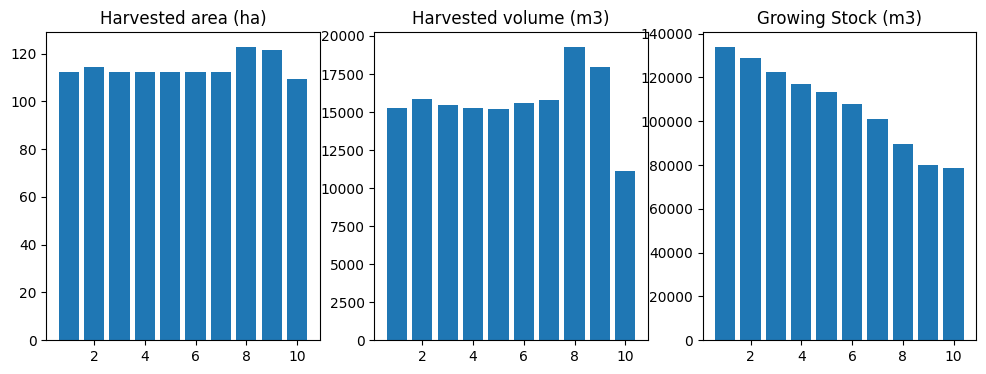

In [46]:
plot_scenario(compile_scenario(fm))

Not bad for a simplistic priority queue heuristic! Using the default `ws3.forest.GreedyAreaSelector` class to select harvest areas is definitely not the only way to simulate harvesting in `ws3`. 

You can always _manually prescribe_ any combination of treatments in any period, and `ws3` will its best to comply. By default `ws3` has several layers of fault protection turned on to avoid crashing with angry-looking error messages every time a user prescribes an invalid action. 

## Implement some manually prescribed harvest actions

Below we reset the `fm` instance (which resets applied actions and inventory to starting positions), the manually prescribe a harvesting actions (using our sample `DevelopmentType` instance from earlier as the target, just as an example). 

First, we try to harvest 1.0 hectare of age 9 stands in period 1.

In [47]:
fm.reset()
fm.apply_action(dtype_key=dt.key, 
                acode='harvest', 
                period=1,
                age=9,
                area=1.0)

not operable
tsa24_clipped 1 2403002 204 2423002 harvest 1 9
(80, 500)


(4, None, None)

No good. Not operable. Also not surprizing, given that we defined harvest operability window to start at age 40 for all development types.

We can use the `operable_dtypes` method to find a suitable target for our harvesting action.

In [48]:
fm.operable_dtypes(acode='harvest', period=1)

{('tsa24_clipped', '1', '2401002', '204', '2401002'): [135,
  105,
  155,
  80,
  113,
  145,
  115,
  85,
  125,
  153,
  91,
  93,
  95],
 ('tsa24_clipped', '1', '2402000', '100', '2402000'): [165],
 ('tsa24_clipped', '1', '2402002', '204', '2402002'): [115, 93, 95],
 ('tsa24_clipped', '1', '2403000', '100', '2403000'): [93]}

In [49]:
fm.operable_area(acode='harvest', period=5, age=40)

0.0

How much area is operable for development type `('tsa24_clipped', '1', '2401002', '204', '2401002')` age 135 in period 1?

In [50]:
fm.operable_area(acode='harvest', period=1, age=135)

72.24421919373785

Harvest 50 ha of that.

In [51]:
fm.apply_action(dtype_key=('tsa24_clipped', '1', '2401002', '204', '2401002'), 
                acode='harvest', 
                period=1,
                age=135,
                area=50.,
                compile_c_ycomps=True)

(0, 0.0, [[('tsa24_clipped', '1', '2401002', '204', '2421002'), 1.0, 0]])

Note that the way we set this model up, the actionned area transitions to develoment type `('tsa24_clipped', '1', '2401002', '204', '2421002')`, which corresponds to second-growth yield curve (as opposed to the first-growth yield curve the area was originally tracking along). We will look for this second-growth development type key below and try to harvest it a second time.

Commit the action. Just roll with it. Normally `ws3` takes care of committing actions at appropriate moments, but you have to do this yourself when running in fully manual mode (like we are doing now).

In [52]:
fm.commit_actions(period=1)

Check the new operable area.

In [53]:
fm.operable_area(acode='harvest', period=1, age=135)

22.244219193737848

22.2 operable ha left. Makes sense.

So, we know that our previously harvested area transitions to development type `('tsa24_clipped', '1', '2401002', '204', '2421002')`. 

We can query the development type object about its period-wise operability.

In [54]:
dtk = ('tsa24_clipped', '1', '2401002', '204', '2421002')
dt = fm.dtypes[dtk]
dt.operability

{'harvest': {1: (80, 500),
  2: (80, 500),
  3: (80, 500),
  4: (80, 500),
  5: (80, 500),
  6: (80, 500),
  7: (80, 500),
  8: (80, 500),
  9: (80, 500),
  10: (80, 500)}}

We can see that it become operable at age 80.

If we inspect the private `_areas` attribute of the develoment type, we can see that there is 0.42 ha of age-20 area in the initial inventory, and a new 50.0 ha that gets created from our harvest action (which is

In [55]:
dt._areas

{0: defaultdict(float, {20: 0.422054121206099}),
 1: defaultdict(float, {20: 0.422054121206099, 0: 50.0}),
 2: defaultdict(float, {30: 0.422054121206099, 10: 50.0}),
 3: defaultdict(float, {40: 0.422054121206099, 20: 50.0}),
 4: defaultdict(float, {50: 0.422054121206099, 30: 50.0}),
 5: defaultdict(float, {60: 0.422054121206099, 40: 50.0}),
 6: defaultdict(float, {70: 0.422054121206099, 50: 50.0}),
 7: defaultdict(float, {80: 0.422054121206099, 60: 50.0}),
 8: defaultdict(float, {90: 0.422054121206099, 70: 50.0}),
 9: defaultdict(float, {100: 0.422054121206099, 80: 50.0}),
 10: defaultdict(float, {110: 0.422054121206099, 90: 50.0})}

We can use the `operable_ages` method to find the first period in which it become operable.

In [56]:
for p in fm.periods: 
    print('period:', p, 
          'operable ages:', dt.operable_ages('harvest', p),
          'operable area:', dt.operable_area('harvest', p))

period: 1 operable ages: [] operable area: 0.0
period: 2 operable ages: [] operable area: 0.0
period: 3 operable ages: [] operable area: 0.0
period: 4 operable ages: [] operable area: 0.0
period: 5 operable ages: [] operable area: 0.0
period: 6 operable ages: [] operable area: 0.0
period: 7 operable ages: [80] operable area: 0.422054121206099
period: 8 operable ages: [90] operable area: 0.422054121206099
period: 9 operable ages: [80, 100] operable area: 50.4220541212061
period: 10 operable ages: [90, 110] operable area: 50.4220541212061


So, the 50 ha of area we previously harvested does not become operable again until period 9.

Try to harvest the same area (now tracking along a second-growth yield curve) a second time.

In [57]:
fm.apply_action(dtype_key=dtk, 
                acode='harvest', 
                period=9,
                age=80,
                area=50.,
                compile_c_ycomps=True)

(0, 0.0, [[('tsa24_clipped', '1', '2401002', '204', '2421002'), 1.0, 0]])

In [58]:
fm.commit_actions(period=9)

Plot results.

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

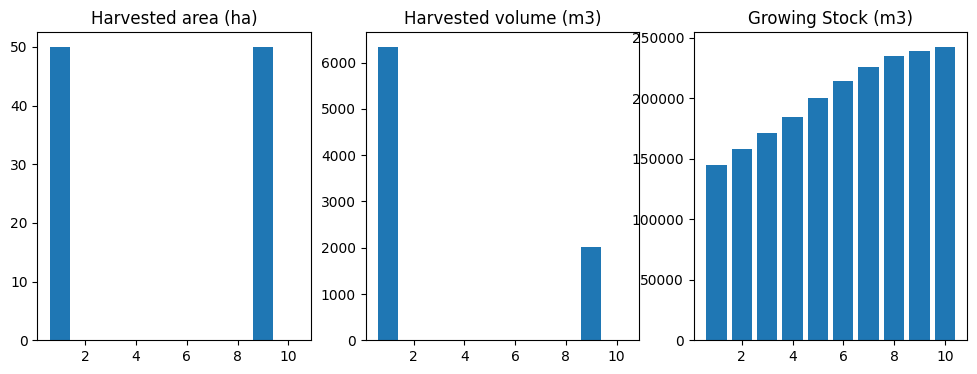

In [59]:
plot_scenario(compile_scenario(fm))

Note that you would rarely (if ever) need to be poking around the guts of your `ws3` model in this way just to schedule some harvesting treatments. The point of the stuff above is to help you understand some of the basic action scheduling and action operability functions (and where the bit live in the `ws3` data model), which in turn are the building blocks of all the higher-level scheduling functions in ws3. 

If you like, take some time now to go have a closer look at the source code for the `GreedyAreaSelector` class in (defined in the `ws3.forest` module). If you look closely, you will see that it is basically just combining all the bit we used in our random-seeming example above (i.e., `operable_dtypes`, `operable_area`, `apply_action`, `commit_actions`), glued together with some `while` loops and `if` conditions and other stuff. Neat, right? 

If you wanted to, you could write your own `AreaSelector` class that uses different logic to select and operate on area in your model (as long as your class has an `__init__` method that sets a `parent` attribute that points back to your `ForestModel` instance and an `operate` method with appropriate args, it should work). You can monkey-patch the `ForestModel.areaselector` attribute at runtime to change the default behaviour of your model as well (several of the fault-recovery functions in the `ForestModel` class use the `areaselector` to find operable area when the things go a bit pear-shaped and you have set up the model to do its best to find operable area and keep going when part of the prescribed action schedule is infeasible). See `ForestModel.repair_actions`, `ForestModel.commit_actions`, `ForestModel.apply_action`, and `ForestModel.apply_schedule` for examples of where the `areaselector` gets used to smooth over bumps in the road.

## Implement optimization-based action scheduling

`ws3` also includes functions to automate the process of formulating and solving linear programming (LP) optimization problems to schedule actions in your model. Using an optimization approach, you formulate your forest-level management problem in terms of an _objective function_ and _constraints_.

`ws3` currently includes functions to formulate and solve Model I type optimization problems, as first documented in Johson and Scheurman (1977).

>Johnson, K.N. and H.L. Scheurman (1977). “Techniques for prescribing optimal
timber harvest and investment under different objectives—discussion and
synthesis”. In: Forest Science Monograph 23.suppl_1.



The optimization problem can be formulated as follows

$$
\begin{align}
  \text{max} \quad &  \sum_{i\in I}\sum_{j \in J_{i}}c_{ij}x_{ij} & \\
  \text{s.t.} \quad & \nonumber\\
   &(1-\varepsilon_{p})y_p \leq \sum_{i\in I}\sum_{j\in J_{i}}\mu_{ijpt}x_{ij}  \leq  (1+\varepsilon_{p})y_p, & \forall p\in O', t\in T'_p \\
   &v^{-}_{ot}\leq\sum_{i\in Z}\sum_{j\in J_{i}}\mu_{ijot}x_{ij}  \leq v^{+}_{ot}, &  \forall o\in O, t\in T \\
   &\sum_{j\in J_{i}}x_{ij}  = 1, \forall i\in Z \\
   &0 \leq x_{ij} \leq 1, & \forall i \in Z, j \in J_{i}
\end{align}
$$

where

$$
\begin{align*}
  I := & \,\, \text{set of spatial zones}\\
  J_{i} := & \,\, \text{set of available prescriptions for zone $i \in I$}\\
  O := & \,\, \text{set of forest outputs}\\
  O' \subseteq O := & \,\, \text{set of targeted forest outputs}\\
  T := & \,\, \text{set of time periods in the planning horizon}\\
  T'_p \subseteq O := & \,\, \text{subset of $T$ on which even-flow constraints for output $p \in O^{\prime}$ are applied}\\
  \varepsilon_{p} := & \,\, \text{admissible level of variation on yield of targeted output $p \in O^{\prime}$} \\
  \mu_{ijot} := & \,\, \text{quantity of output $o \in O$ produced in period $t \in T$ by prescription $j \in J_{i}$}\\
                     & \,\, \text{in zone $i \in I$}\\
  \mu_{ijpt} := & \,\, \text{quantity of output $p \in O'$ produced in period $t \in T$ by prescription $j \in J_{i}$}\\
                     & \,\, \text{in zone $i \in I$}\\
  v^{-}_{ot} := & \,\, \text{lower bound on yield of output $o \in O$ in period $t \in T$} \\
  v^{+}_{ot} := & \,\, \text{upper bound on yield of output $o \in O$ in period $t \in T$} \\
  c_{ij} := & \,\,  \text{objective function contribution of prescription $j \in J_{i}$ in zone $i \in I$} \\
  x_{ij} := & \,\, \text{proportion of zone $i \in Z$ on which prescription $j \in J_{i}$ is applied} \\
  y_p = &  \sum_{i\in I}\sum_{j\in J_i}\mu_{ijpt^R_p}x_{ij}\text{, i.e. total yield of targeted output $p \in O'$ at reference period $t^R_p$} 
\end{align*}
$$

The objective function maximizes the sum of $c_{ij}x_{ij}$ products, which represent yield of a user-defined output---the output can be anything, but common examples include maximizing harvest volume or minimizing harvest area. Other, more complex objectives functions can be defined (e.g., minimize a penalty-based weighted multi-objective goal programming objective function).

The variables $x_{ij}$ are linear, with domain $\{x_{ij} \in \mathbb{R}|0 \leq x_{ij} \leq 1\}$. Coverage constraints require prescriptions to cover the entire zone---doing nothing for the entire planning horizon is considered a prescription that could generate some outputs. Variable bounds and coverage constraints are automatically set by the `ws3` optimization problem formulation functions.


The set $O^{\prime} \subseteq O$ represents targeted outputs, for which we enforce even-flow constraints.
Even-flow constraints are expressed in terms of $y_p$, which represents total yield of targeted output $p \in O^{\prime}$ in reference period $t^R_p$.
Note that even-flow constraints are defined over time periods $T'_p$, which is any subset of $T$ (need not be contiguous)---$T'_p$ can be unique for each output  $p \in O^{\prime}$.

General constraints set upper and lower bounds on periodic yield of any output $o \in O$---we use these constraints to set minimum and maximum levels of any performance indicator defined in the model (or combinations thereof). 

Below we show an example of using the optimization functins in `ws3` to formulate and solve a Model I probleml.

You will need to have `gurobipy` installed for this next step to work. At some point I will finish implementing bindings to the PuLP open-source solver library, but for now we are stuck with Gurobi as the only solver that works with ws3. 

You should be able to install `gurobipy` using the magic `%pip` command below, however this _only_ installs the Python module and minimal solver binaries. This _does not_ install the full Gurobi software stack, do the Gurobi licence managent tools (including the `grbgetkey` command) are _not_ installed automatically with the Python module. The `gurobipy` installation includes a limited software license that should allow you to solve _small_ problem instances, but will puke if you try to solve anything too large (which includes most `ws3` problems, unless you model is extremely small and simple). 

If you are eligible for an academic license, you should request and install a "Named-User Acacdemic" license from the Licenses tab in the [Gurobi User Portal](https://portal.gurobi.com/iam/licenses/request) (create a new Gurobi account if you do not have one yet, using your official academic institution email address). This license is per-user, per-machine, is valid for one year, should _only_ be used in an academic context (see [Gurobi Standard EULA](https://cdn.gurobi.com/wp-content/uploads/Gurobi_Standard_EULA_Nov2022.pdf) for details of license terms and restrictions).

**Hint:** If you get a `grbgetkey: command not found` error, either the full Gurobi software stack is not installed at all on your system, or is installed but `grbgetkey` is not in your path. Depending on your situation, either [install the full Gurobi software stack](https://support.gurobi.com/hc/en-us/articles/4534161999889) or specify the full path to the `grbgetkey` command (Gurobi installation instructions recommend installing Gurobi into `/opt/gurobi` on linux platforms).   

In [60]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [61]:
import gurobipy as grb

First we need to define a few utility functions that we will use to build the problems (e.g., objective function coefficient function, even flow constraint coefficient function, general constraint coefficient function).

Note that the `spades_ws3` project contains several useful chunks of code that you can use as a starting point (on GitHub, see link below).

https://github.com/gparadis/spades_ws3/blob/master/python/spadesws3.py

In [62]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem.

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [63]:
def gen_scenario(fm, name='base', util=0.85, harvest_acode='harvest',
                 cflw_ha={}, cflw_hv={}, 
                 cgen_ha={}, cgen_hv={}, cgen_gs={}, 
                 tvy_name='totvol', obj_mode='max_hv', mask=None):
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_ha': # minimize harvest area
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)        
    coeff_funcs['z'] = partial(cmp_c_z, expr=zexpr) # define objective function coefficient function  
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_hv         
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

We need to add a "null" action to the model for the optimization functions to work correctly. This is basically a pass-through action that literally does nothing (i.e., just grow the forest for one time step, which `ws3` models as an explicit decision option in the dynamic programming state trees it builds when it generates the LP problem matrix).

In [64]:
fm.add_null_action()

We define some scenario options below. Specify which scenario by setting the `scenario_name` variable below.

In [65]:
def run_scenario(fm, scenario_name='base', solver=ws3.opt.SOLVER_PULP):
    import sys
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    
    # define harvest area and harvest volume flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
    elif scenario_name == 'base-cgen_ha': 
        # Base scenario, plus harvest area general constraints
        print('running base scenario plus harvest area constraints')
        cgen_ha = {'lb':{1:0.}, 'ub':{1:100.}}    
    elif scenario_name == 'base-cgen_hv': 
        # Base scenario, plus harvest volume general constraints
        print('running base scenario plus harvest volume constraints')
        cgen_hv = {'lb':{1:0.}, 'ub':{1:10000.}}    
    elif scenario_name == 'base-cgen_gs': 
        # Base scenario, plus growing stock general constraints
        print('running base scenario plus growing stock constraints')
        cgen_gs = {'lb':{10:120000.}, 'ub':{10:1000000.}}
    else:
        assert False # bad scenario name

    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs)
    p.solver(solver)

    fm.reset()
    p.solve()

    if p.status() != ws3.opt.STATUS_OPTIMAL:
        print('Model not optimal.')
        df = None   
    else:
        sch = fm.compile_schedule(p)
        fm.apply_schedule(sch, 
                        force_integral_area=False, 
                        override_operability=False,
                        fuzzy_age=False,
                        recourse_enabled=False,
                        verbose=False,
                        compile_c_ycomps=True)
        df = compile_scenario(fm)
        fig, ax = plot_scenario(df)
    return fig, df, p

Note that the `Problem.solve` method return a reference to the lower-level `gurobi.Model` object in case we need or want to poke around it (can yield insight into how the optimization problem is formulated on the solver side of things, or help debug).

Be vigilant for "infeasible or unbounded model" messages and such below, in case these are unexpected. Depending on how the rest of the model was set up, `ws3` may automatically attempt to resolve infeasible models using "feasibility relaxation" mode in Gurobi (which might not be what you want, depending on the situation).

running base scenario
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1e76eeefad2b440e814958ebed28da98-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/1e76eeefad2b440e814958ebed28da98-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 77 COLUMNS
At line 3296 RHS
At line 3369 BOUNDS
At line 3659 ENDATA
Problem MODEL has 72 rows, 289 columns and 2961 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 60 (-12) rows, 257 (-32) columns and 2753 (-208) elements
0  Obj -0 Dual inf 1648115.1 (257)
31  Obj 274206.44 Primal inf 263.04707 (27)
62  Obj 190487.47 Primal inf 20.717794 (19)
94  Obj 188371.61 Primal inf 0.083498685 (1)
95  Obj 188371.61
Optimal - objective value 188371.61
After Postsolve, objective 188371.61, infeasibilities - dual 0 (0), pri

(<Figure size 1200x400 with 3 Axes>,
    period         oha           ohv            ogs
 0       1  141.884535  18776.518250  129802.193297
 1       2  134.790309  17837.692412  122458.829241
 2       3  134.790309  17837.692363  113354.435693
 3       4  134.790309  17837.692369  104521.374395
 4       5  134.790309  18086.166846   96456.943325
 5       6  134.790310  19715.344321   85374.110531
 6       7  147.721252  19715.344047   72562.743828
 7       8  135.688774  19715.344193   59660.980420
 8       9  148.978762  19134.468780   49258.413269
 9      10  148.978762  19715.344139   37323.465106,
 <ws3.opt.Problem at 0x7d3a8fb87ad0>)

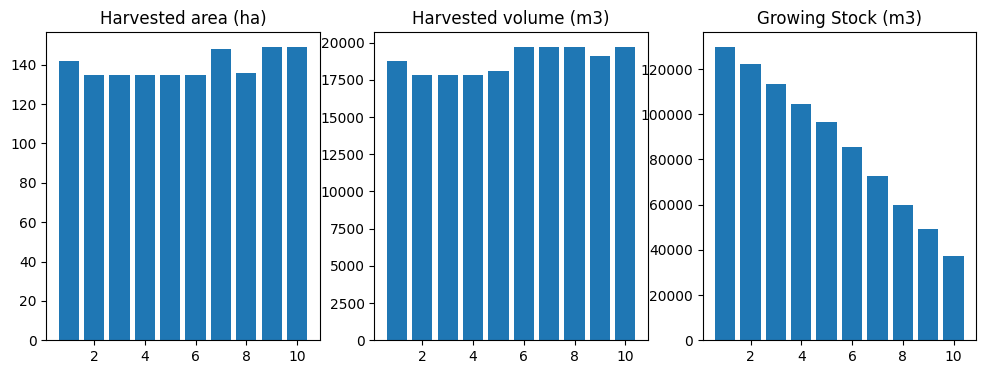

In [66]:
run_scenario(fm, 'base')

running base scenario plus harvest area constraints
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/79ad96d048f7497287d2378e8f97a850-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/79ad96d048f7497287d2378e8f97a850-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 79 COLUMNS
At line 3386 RHS
At line 3461 BOUNDS
At line 3751 ENDATA
Problem MODEL has 74 rows, 289 columns and 3049 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 61 (-13) rows, 257 (-32) columns and 2797 (-252) elements
0  Obj -0 Dual inf 1648115.1 (257)
37  Obj 218827.26 Primal inf 187.68796 (30)
72  Obj 156478.82 Primal inf 48.47544 (21)
110  Obj 151255.19 Primal inf 44.825518 (23)
141  Obj 149655.59 Primal inf 0.18591372 (2)
145  Obj 149640.92
Optimal - objective value 149640

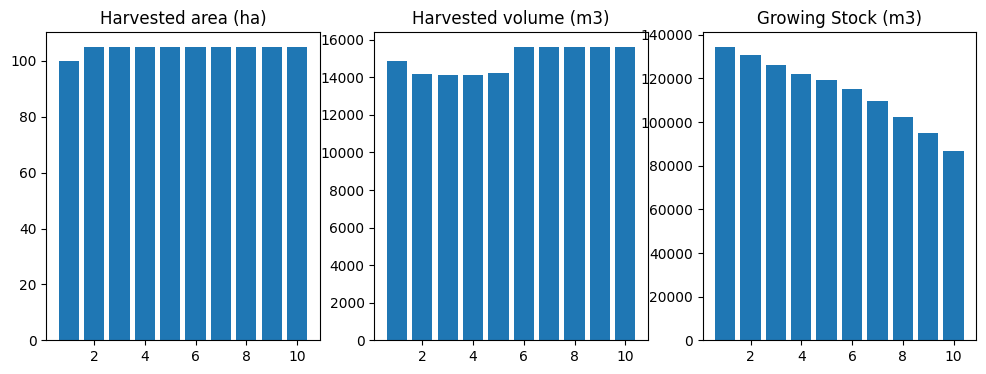

In [67]:
fig, df, problem = run_scenario(fm, 'base-cgen_ha')

running base scenario plus harvest volume constraints
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e123b842041e424cb2a272893ff5b13d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/e123b842041e424cb2a272893ff5b13d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 79 COLUMNS
At line 3386 RHS
At line 3461 BOUNDS
At line 3751 ENDATA
Problem MODEL has 74 rows, 289 columns and 3049 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 61 (-13) rows, 257 (-32) columns and 2797 (-252) elements
0  Obj -0 Dual inf 1648115.1 (257)
31  Obj 257136.28 Primal inf 692.60904 (41)
69  Obj 132447.69 Primal inf 428.12712 (39)
102  Obj 132447.69 Primal inf 235.257 (36)
144  Obj 104500 Primal inf 63.580769 (32)
175  Obj 104500 Primal inf 36.186236 (27)
206  Obj 10

(<Figure size 1200x400 with 3 Axes>,
    period        oha           ohv            ogs
 0       1  80.103782   9999.999985  140127.508903
 1       2  84.108971  10500.000034  141369.814621
 2       3  84.108971  10499.999989  140989.357652
 3       4  84.108970  10499.999847  140762.870892
 4       5  81.631061  10499.999992  141717.165422
 5       6  82.813938  10499.999893  141719.986650
 6       7  76.098593  10499.999963  139603.975428
 7       8  78.353431  10500.000357  136332.663278
 8       9  84.108971  10499.999983  133304.156419
 9      10  84.108971  10500.000006  128523.377807,
 <ws3.opt.Problem at 0x7d3a94f44920>)

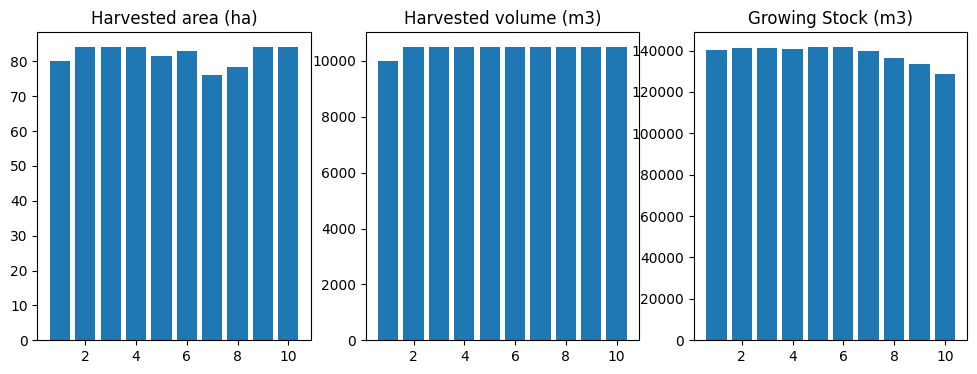

In [68]:
run_scenario(fm, 'base-cgen_hv')

running base scenario plus growing stock constraints
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gep/projects/ws3/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6b11bf85bc9a4b08a367d0aceb96f9f3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/6b11bf85bc9a4b08a367d0aceb96f9f3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 79 COLUMNS
At line 3590 RHS
At line 3665 BOUNDS
At line 3955 ENDATA
Problem MODEL has 74 rows, 289 columns and 3253 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 61 (-13) rows, 281 (-8) columns and 2915 (-338) elements
0  Obj -0 Primal inf 1217.5815 (25) Dual inf 3373056.7 (257)
31  Obj 206459.38 Primal inf 1145.513 (38)
62  Obj 133758.81 Primal inf 350.68698 (32)
93  Obj 128819.49 Primal inf 44.297713 (16)
124  Obj 127135.46
Optimal - objective value 127135.46
After Postsolve,

(<Figure size 1200x400 with 3 Axes>,
    period        oha           ohv            ogs
 0       1  93.081607  13039.534091  136551.586426
 1       2  97.735687  13691.510811  133453.764565
 2       3  88.427526  13691.510729  128413.423102
 3       4  90.425830  12387.557414  125671.076910
 4       5  90.642853  12387.557299  124871.681847
 5       6  92.350775  12387.557364  124426.889792
 6       7  91.844362  12387.557393  124024.129732
 7       8  90.851291  12387.557367  123436.887975
 8       9  90.052194  12387.557264  122106.393677
 9      10  88.427526  12387.557340  120000.000202,
 <ws3.opt.Problem at 0x7d3b244acf80>)

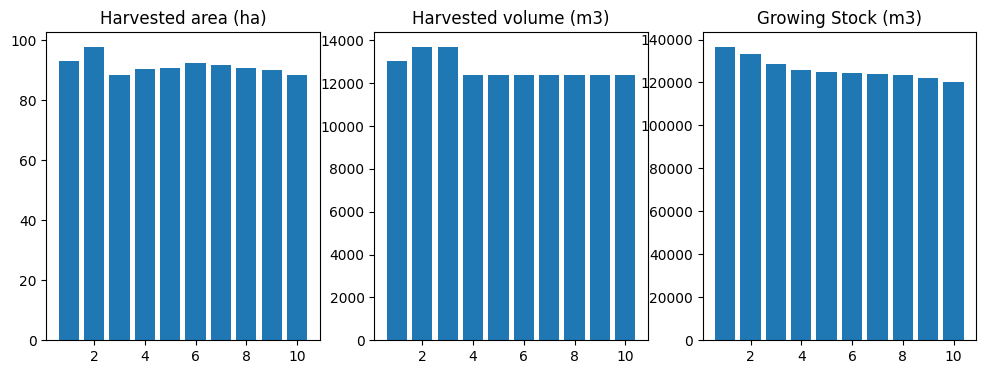

In [69]:
run_scenario(fm, 'base-cgen_gs')

Ta da!

## Instantiate `ForestModel` from Woodstock-format model input text files

Start by creating a new directory to hold the model definition files.

Woodstock models are defined in terms of a number of _sections_. The sections can be defined in a single text file, or in separate text files. We will use separate text files for each section in this example.

Our model will include the following sections:

LANDSCAPE
AREAS
YIELD
ACTIONS
TRANSITIONS

There are other possible sections that one can include in a Woodstock model, which will not include here. This is not intended to be a comprehensive overview of Woodstock-format model definition. Refer to the Woodstock technical documentation for the complete story.

> Note! Although we tried to make both the handed-coded model above and the Woodstock-format model below as similar as possible, a few differences have slipped in and the models are not totally equivalent (which explains why the same call to `schedule_harvest_areacontrol` produces somewhat different results. 

> This should not compromise the purpose of this notebook, but can be a bit distracting if you start comparing output from both parts of the example. We will try to fix this at some point to make output from both model match well enough that the differences will not be so evident to the naked eye.

In [70]:
!mkdir data/_woodstock_model_files

mkdir: cannot create directory ‘data/_woodstock_model_files’: File exists


### `LANDSCAPE` section

The `LANDSCAPE` section defines themes (i.e., state variables), theme basecodes (i.e., valid state variable values), and theme aggregates (i.e., groups of state variable values within a given theme, which can include aggregates with no [documented] limit on recursion depth).

We can start by printing `fm._theme_basecodes`, to provide a "cheat sheet" for the values we need to code into the `LANDSCAPE` section of our Woodstock model definition.

In [71]:
fm._theme_basecodes

[['tsa24_clipped'],
 ['1', '0'],
 ['2403004',
  '2402004',
  '2401006',
  '2403002',
  '2402002',
  '2401004',
  '2402001',
  '2402000',
  '2403001',
  '2402003',
  '2403007',
  '2403000',
  '2401002',
  '2401005',
  '2402005',
  '2403003',
  '2401000',
  '2401003',
  '2402006',
  '2402007',
  '2401001',
  '2403005',
  '2403006',
  '2401007'],
 ['304', '100', '204', '1201', '104'],
 ['2422003',
  '2403004',
  '2402004',
  '2401006',
  '2422002',
  '2423003',
  '2403002',
  '2422007',
  '2423001',
  '2423000',
  '2402002',
  '2401004',
  '2402001',
  '2421007',
  '2423007',
  '2402000',
  '2403001',
  '2423002',
  '2422000',
  '2402003',
  '2423004',
  '2403007',
  '2401002',
  '2403000',
  '2401005',
  '2402005',
  '2421002',
  '2403003',
  '2401000',
  '2401003',
  '2402006',
  '2402007',
  '2401001',
  '2403005',
  '2403006',
  '2422004',
  '2401007']]

Print the THEME values to a format that we can easily copy and past into our text file to speed up coding this up.

In [72]:
for v in fm._theme_basecodes[2]: print(v)

2403004
2402004
2401006
2403002
2402002
2401004
2402001
2402000
2403001
2402003
2403007
2403000
2401002
2401005
2402005
2403003
2401000
2401003
2402006
2402007
2401001
2403005
2403006
2401007


In [73]:
for v in fm._theme_basecodes[3]: print(v)

304
100
204
1201
104


In [74]:
for v in fm._theme_basecodes[4]: print(v)

2422003
2403004
2402004
2401006
2422002
2423003
2403002
2422007
2423001
2423000
2402002
2401004
2402001
2421007
2423007
2402000
2403001
2423002
2422000
2402003
2423004
2403007
2401002
2403000
2401005
2402005
2421002
2403003
2401000
2401003
2402006
2402007
2401001
2403005
2403006
2422004
2401007


In [75]:
landscape_section = \
"""
*THEME Timber Supply Area (TSA)
tsa24_clipped

*THEME Timber Harvesting Land Base (THLB)
0
1

*THEME Analysis Unit (AU)
2402002
2401007
2402001
2401005
2402000
2403004
2403006
2401004
2401006
2402004
2402007
2403005
2401002
2403007
2403003
2401000
2402005
2402006
2401003
2403002
2402003
2403000
2401001
2403001

*THEME Leading tree species (CANFI species code)
304
100
1201
204
104

*THEME Yield curve ID
2402002
2401007
2422007
2402001
2401005
2422003
2402000
2403004
2423004
2403006
2421007
2423003
2401004
2401006
2402004
2421002
2422004
2423002
2422002
2402007
2403005
2401002
2403007
2423007
2403003
2401000
2402005
2402006
2401003
2423001
2403002
2402003
2422000
2403000
2401001
2423000
2403001
"""

In [76]:
with open('data/_woodstock_model_files/tsa24_clipped.lan', 'w') as f: f.write(landscape_section)

### `AREAS` section

The `AREAS` section defines the initial inventory, as area by development type and age. 

Rather can manually code this section (which would be long and also prone to user error), we can use a bit of code to print the required information in the correct format (which we can then copy and paste).

In [77]:
for name, group in gstands:
    dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
    print('*A', ' '.join(v for v in dtk), age, area)

*A tsa24_clipped 0 2401000 100 2401000 85 15.182274886309896
*A tsa24_clipped 0 2401000 100 2401000 95 20.653788842921458
*A tsa24_clipped 0 2401000 100 2401000 105 1.109374490200082
*A tsa24_clipped 0 2401000 100 2401000 125 25.73174833461312
*A tsa24_clipped 0 2401000 100 2401000 135 62.02382759721078
*A tsa24_clipped 0 2401000 100 2401000 145 45.32228954967691
*A tsa24_clipped 0 2401000 100 2401000 155 3.052804424896181
*A tsa24_clipped 0 2402005 1201 2402005 85 1.812979326195168
*A tsa24_clipped 1 2401002 204 2401002 78 103.76740323520823
*A tsa24_clipped 1 2401002 204 2401002 80 4.173147018452507
*A tsa24_clipped 1 2401002 204 2401002 85 282.1296355046733
*A tsa24_clipped 1 2401002 204 2401002 91 73.1021561503533
*A tsa24_clipped 1 2401002 204 2401002 93 28.37956666951611
*A tsa24_clipped 1 2401002 204 2401002 95 94.94675966211176
*A tsa24_clipped 1 2401002 204 2401002 105 32.175418531537815
*A tsa24_clipped 1 2401002 204 2401002 113 4.184826329641321
*A tsa24_clipped 1 2401002 20

In [78]:
areas_section = \
"""
*A tsa24_clipped 0 2401000 100 2401000 85 15.182274886309896
*A tsa24_clipped 0 2401000 100 2401000 95 20.653788842921458
*A tsa24_clipped 0 2401000 100 2401000 105 1.109374490200082
*A tsa24_clipped 0 2401000 100 2401000 125 25.73174833461312
*A tsa24_clipped 0 2401000 100 2401000 135 62.02382759721078
*A tsa24_clipped 0 2401000 100 2401000 145 45.32228954967691
*A tsa24_clipped 0 2401000 100 2401000 155 3.052804424896181
*A tsa24_clipped 0 2402005 1201 2402005 85 1.812979326195168
*A tsa24_clipped 1 2401002 204 2401002 78 103.76740323520823
*A tsa24_clipped 1 2401002 204 2401002 80 4.173147018452507
*A tsa24_clipped 1 2401002 204 2401002 85 282.1296355046733
*A tsa24_clipped 1 2401002 204 2401002 91 73.1021561503533
*A tsa24_clipped 1 2401002 204 2401002 93 28.37956666951611
*A tsa24_clipped 1 2401002 204 2401002 95 94.94675966211176
*A tsa24_clipped 1 2401002 204 2401002 105 32.175418531537815
*A tsa24_clipped 1 2401002 204 2401002 113 4.184826329641321
*A tsa24_clipped 1 2401002 204 2401002 115 50.030816858894816
*A tsa24_clipped 1 2401002 204 2401002 125 78.16612132001225
*A tsa24_clipped 1 2401002 204 2401002 135 72.24421919373785
*A tsa24_clipped 1 2401002 204 2401002 145 96.38442685503642
*A tsa24_clipped 1 2401002 204 2401002 153 9.591469412607397
*A tsa24_clipped 1 2401002 204 2401002 155 34.32629241113743
*A tsa24_clipped 1 2401002 204 2421002 20 0.422054121206099
*A tsa24_clipped 1 2402000 100 2402000 165 0.638005468748551
*A tsa24_clipped 1 2402002 204 2402002 78 32.64168183055375
*A tsa24_clipped 1 2402002 204 2402002 93 48.21816452980633
*A tsa24_clipped 1 2402002 204 2402002 95 33.89498244313859
*A tsa24_clipped 1 2402002 204 2402002 115 3.195378954654358
*A tsa24_clipped 1 2403000 100 2403000 93 14.811643286926836
*A tsa24_clipped 1 2403002 204 2403002 73 2.243990590272984
*A tsa24_clipped 1 2403002 204 2423002 9 59.81429119367274
*A tsa24_clipped 1 2403002 204 2423002 18 32.366198551219505
"""

In [79]:
with open('data/_woodstock_model_files/tsa24_clipped.are', 'w') as f: f.write(areas_section)

### `YIELDS` section

The `YIELDS` section defines yield curves and links these to development types.

We can use a bit of code to output the required data in the correct format. It would be possible to manually code this (like any other section) but would be long and error prone.

In [80]:
#fm.yields

In [81]:
for au_id, au_row in au_table.iterrows():
    yname = 's%04d' % int(au_row.canfi_species)
    for is_managed in (0, 1):
        curve_id = au_row.unmanaged_curve_id if not is_managed else au_row.managed_curve_id
        mask = ('?', '?', str(au_id), '?', str(curve_id))
        points = [(r.x, r.y) for _, r in curve_points_table.loc[curve_id].iterrows() if not r.x % period_length and r.x <= max_age]
        c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=fm.max_age, period_length=period_length)
        print('*Y', ' '.join(v for v in mask))
        print(yname, '1', ' '.join(str(int(c[x])) for x in range(fm.period_length, 300+fm.period_length, fm.period_length)))

*Y ? ? 2401000 ? 2401000
s0100 1 0 1 5 10 16 24 33 43 54 64 75 85 95 104 113 121 127 133 138 143 146 148 150 151 151 150 149 147 145 145
*Y ? ? 2401000 ? 2401000
s0100 1 0 1 5 10 16 24 33 43 54 64 75 85 95 104 113 121 127 133 138 143 146 148 150 151 151 150 149 147 145 145
*Y ? ? 2402000 ? 2402000
s0100 1 4 13 27 42 58 76 93 110 126 141 156 169 182 193 203 211 219 225 231 235 238 240 242 242 242 241 240 238 235 235
*Y ? ? 2402000 ? 2422000
s0100 1 0 0 0 0 3 18 46 79 112 144 171 195 215 234 248 261 272 282 290 298 305 311 316 320 325 328 330 333 335 336
*Y ? ? 2403000 ? 2403000
s0100 1 3 15 37 67 99 133 166 197 225 250 272 290 305 316 325 330 333 333 331 328 322 316 308 299 289 279 268 257 246 246
*Y ? ? 2403000 ? 2423000
s0100 1 0 0 0 5 38 88 142 190 231 265 293 315 334 350 365 377 388 396 403 410 416 420 424 427 429 431 433 433 433 433


*Y ? ? 2401001 ? 2401001
s0304 1 0 0 0 0 0 0 2 5 11 18 25 32 40 47 54 62 66 70 75 79 83 88 92 94 95 97 97 97 97 97
*Y ? ? 2401001 ? 2401001
s0304 1 0 0 0 0 0 0 2 5 11 18 25 32 40 47 54 62 66 70 75 79 83 88 92 94 95 97 97 97 97 97
*Y ? ? 2402001 ? 2402001
s0304 1 0 0 0 0 0 3 8 17 29 43 57 71 84 96 107 117 125 132 138 143 146 149 150 151 151 150 149 146 144 144
*Y ? ? 2402001 ? 2402001
s0304 1 0 0 0 0 0 3 8 17 29 43 57 71 84 96 107 117 125 132 138 143 146 149 150 151 151 150 149 146 144 144
*Y ? ? 2403001 ? 2403001
s0304 1 0 0 1 6 16 30 48 68 87 106 123 140 154 167 178 188 195 201 206 209 210 211 210 209 206 203 199 195 190 190
*Y ? ? 2403001 ? 2423001
s0304 1 0 0 0 0 0 0 6 21 43 70 97 126 152 176 199 218 236 252 265 277 288 297 306 314 321 326 331 336 339 340
*Y ? ? 2401002 ? 2401002
s0204 1 0 4 12 25 40 57 73 89 103 116 128 137 145 152 157 160 162 163 163 162 160 158 154 151 147 142 137 132 127 127
*Y ? ? 2401002 ? 2421002
s0204 1 0 0 0 0 1 7 23 47 71 94 114 132 146 157 166 173 179 183

In [82]:
yields_section = \
"""
*Y ? ? 2401000 ? 2401000
s0100 1 0 1 5 10 16 24 33 43 54 64 75 85 95 104 113 121 127 133 138 143 146 148 150 151 151 150 149 147 145 145
*Y ? ? 2401000 ? 2401000
s0100 1 0 1 5 10 16 24 33 43 54 64 75 85 95 104 113 121 127 133 138 143 146 148 150 151 151 150 149 147 145 145
*Y ? ? 2402000 ? 2402000
s0100 1 4 13 27 42 58 76 93 110 126 141 156 169 182 193 203 211 219 225 231 235 238 240 242 242 242 241 240 238 235 235
*Y ? ? 2402000 ? 2422000
s0100 1 0 0 0 0 3 18 46 79 112 144 171 195 215 234 248 261 272 282 290 298 305 311 316 320 325 328 330 333 335 336
*Y ? ? 2403000 ? 2403000
s0100 1 3 15 37 67 99 133 166 197 225 250 272 290 305 316 325 330 333 333 331 328 322 316 308 299 289 279 268 257 246 246
*Y ? ? 2403000 ? 2423000
s0100 1 0 0 0 5 38 88 142 190 231 265 293 315 334 350 365 377 388 396 403 410 416 420 424 427 429 431 433 433 433 433
*Y ? ? 2401001 ? 2401001
s0304 1 0 0 0 0 0 0 2 5 11 18 25 32 40 47 54 62 66 70 75 79 83 88 92 94 95 97 97 97 97 97
*Y ? ? 2401001 ? 2401001
s0304 1 0 0 0 0 0 0 2 5 11 18 25 32 40 47 54 62 66 70 75 79 83 88 92 94 95 97 97 97 97 97
*Y ? ? 2402001 ? 2402001
s0304 1 0 0 0 0 0 3 8 17 29 43 57 71 84 96 107 117 125 132 138 143 146 149 150 151 151 150 149 146 144 144
*Y ? ? 2402001 ? 2402001
s0304 1 0 0 0 0 0 3 8 17 29 43 57 71 84 96 107 117 125 132 138 143 146 149 150 151 151 150 149 146 144 144
*Y ? ? 2403001 ? 2403001
s0304 1 0 0 1 6 16 30 48 68 87 106 123 140 154 167 178 188 195 201 206 209 210 211 210 209 206 203 199 195 190 190
*Y ? ? 2403001 ? 2423001
s0304 1 0 0 0 0 0 0 6 21 43 70 97 126 152 176 199 218 236 252 265 277 288 297 306 314 321 326 331 336 339 340
*Y ? ? 2401002 ? 2401002
s0204 1 0 4 12 25 40 57 73 89 103 116 128 137 145 152 157 160 162 163 163 162 160 158 154 151 147 142 137 132 127 127
*Y ? ? 2401002 ? 2421002
s0204 1 0 0 0 0 1 7 23 47 71 94 114 132 146 157 166 173 179 183 187 190 191 192 193 194 195 195 195 196 196 196
*Y ? ? 2402002 ? 2402002
s0204 1 5 18 37 57 79 101 122 142 160 176 191 203 214 222 229 233 237 238 239 238 236 233 229 224 219 213 207 201 194 194
*Y ? ? 2402002 ? 2422002
s0204 1 0 0 0 1 16 55 100 143 180 208 231 247 261 271 278 282 286 288 289 290 291 292 292 293 293 293 293 293 293 293
*Y ? ? 2403002 ? 2403002
s0204 1 8 29 59 93 129 165 200 232 261 287 309 328 343 355 363 368 371 371 369 365 359 352 344 334 324 313 301 290 277 277
*Y ? ? 2403002 ? 2423002
s0204 1 0 0 0 24 98 184 257 312 353 380 400 413 422 428 433 435 436 437 436 434 433 431 430 429 428 428 428 428 428 428
*Y ? ? 2401003 ? 2401003
s0304 1 0 0 0 1 6 15 27 42 58 74 89 103 116 127 137 145 152 157 161 164 166 167 166 165 163 161 158 154 150 150
*Y ? ? 2401003 ? 2401003
s0304 1 0 0 0 1 6 15 27 42 58 74 89 103 116 127 137 145 152 157 161 164 166 167 166 165 163 161 158 154 150 150
*Y ? ? 2402003 ? 2402003
s0304 1 0 0 2 9 22 42 67 94 120 145 168 189 207 222 235 245 252 258 261 262 261 259 255 251 245 238 231 223 215 215
*Y ? ? 2402003 ? 2422003
s0304 1 0 0 0 0 0 6 25 52 84 117 150 180 206 228 247 263 277 290 301 311 319 327 333 338 342 347 350 353 357 358
*Y ? ? 2403003 ? 2403003
s0304 1 6 25 53 86 120 155 189 220 249 275 297 315 330 342 350 356 359 359 357 354 348 341 333 324 314 304 293 281 270 270
*Y ? ? 2403003 ? 2423003
s0304 1 0 0 0 1 17 60 114 170 221 264 299 327 352 372 390 404 416 426 435 443 450 456 461 466 469 471 473 474 475 476
*Y ? ? 2401004 ? 2401004
s0104 1 0 0 0 0 0 2 6 12 22 33 45 58 70 83 94 105 115 125 133 139 145 150 154 157 159 160 160 159 158 158
*Y ? ? 2401004 ? 2401004
s0104 1 0 0 0 0 0 2 6 12 22 33 45 58 70 83 94 105 115 125 133 139 145 150 154 157 159 160 160 159 158 158
*Y ? ? 2402004 ? 2402004
s0104 1 0 0 0 1 4 11 22 35 51 68 87 106 125 142 159 174 188 199 209 216 222 225 227 228 226 224 220 215 209 209
*Y ? ? 2402004 ? 2422004
s0104 1 0 0 0 0 0 0 5 18 37 60 85 111 134 156 176 194 210 224 236 247 257 265 273 280 286 291 296 300 303 304
*Y ? ? 2403004 ? 2403004
s0104 1 0 0 1 6 16 33 55 80 105 129 153 175 195 213 229 242 253 262 269 274 277 279 279 277 275 271 267 261 255 255
*Y ? ? 2403004 ? 2423004
s0104 1 0 0 0 0 1 10 33 63 98 133 165 195 222 245 266 284 301 316 329 341 351 360 368 374 380 384 387 390 393 394
*Y ? ? 2401005 ? 2401005
s1201 1 2 12 30 53 78 102 124 144 160 174 184 191 196 198 198 196 193 188 182 175 168 161 153 145 137 129 120 112 105 105
*Y ? ? 2401005 ? 2401005
s1201 1 2 12 30 53 78 102 124 144 160 174 184 191 196 198 198 196 193 188 182 175 168 161 153 145 137 129 120 112 105 105
*Y ? ? 2402005 ? 2402005
s1201 1 8 30 59 89 118 146 170 191 208 221 230 237 240 240 238 234 229 222 214 205 196 186 176 166 156 146 137 127 118 118
*Y ? ? 2402005 ? 2402005
s1201 1 8 30 59 89 118 146 170 191 208 221 230 237 240 240 238 234 229 222 214 205 196 186 176 166 156 146 137 127 118 118
*Y ? ? 2403005 ? 2403005
s1201 1 10 37 73 111 148 183 214 240 260 276 287 294 297 296 292 286 278 268 258 246 233 220 208 195 182 169 158 146 135 135
*Y ? ? 2403005 ? 2403005
s1201 1 10 37 73 111 148 183 214 240 260 276 287 294 297 296 292 286 278 268 258 246 233 220 208 195 182 169 158 146 135 135
*Y ? ? 2401006 ? 2401006
s1201 1 4 17 35 57 79 101 121 139 155 168 179 187 193 197 199 199 198 196 192 188 182 176 170 163 156 149 142 134 127 127
*Y ? ? 2401006 ? 2401006
s1201 1 4 17 35 57 79 101 121 139 155 168 179 187 193 197 199 199 198 196 192 188 182 176 170 163 156 149 142 134 127 127
*Y ? ? 2402006 ? 2402006
s1201 1 8 30 59 90 121 150 176 199 219 234 246 255 260 262 262 260 255 249 242 234 225 215 205 195 184 174 164 154 144 144
*Y ? ? 2402006 ? 2402006
s1201 1 8 30 59 90 121 150 176 199 219 234 246 255 260 262 262 260 255 249 242 234 225 215 205 195 184 174 164 154 144 144
*Y ? ? 2403006 ? 2403006
s1201 1 9 35 69 106 143 178 210 237 260 279 293 302 308 310 309 306 300 292 283 273 261 250 237 225 212 199 187 175 163 163
*Y ? ? 2403006 ? 2403006
s1201 1 9 35 69 106 143 178 210 237 260 279 293 302 308 310 309 306 300 292 283 273 261 250 237 225 212 199 187 175 163 163
*Y ? ? 2401007 ? 2401007
s0100 1 0 0 3 12 27 47 71 95 119 140 160 177 191 203 213 220 225 228 229 228 226 223 218 213 207 200 193 186 178 178
*Y ? ? 2401007 ? 2421007
s0100 1 0 0 0 0 3 19 49 83 118 151 180 205 226 245 261 275 286 296 305 313 320 327 332 337 341 344 347 350 352 353
*Y ? ? 2402007 ? 2402007
s0100 1 0 2 12 29 54 83 113 142 170 194 216 235 250 263 272 278 282 283 283 280 276 270 263 256 247 238 229 219 209 209
*Y ? ? 2402007 ? 2422007
s0100 1 0 0 0 2 24 65 114 161 201 235 264 288 307 323 338 351 362 371 379 385 391 396 401 405 407 410 412 413 414 415
*Y ? ? 2403007 ? 2403007
s0100 1 6 28 61 100 143 186 226 264 297 326 350 370 384 395 402 404 404 401 395 387 378 367 354 341 327 313 298 284 269 269
*Y ? ? 2403007 ? 2423007
s0100 1 0 0 0 30 99 177 244 300 343 378 407 432 452 468 483 495 505 513 519 523 526 529 531 534 535 535 535 535 536 535
*YC ? ? ? ? ?
totvol _SUM(s0100, s0204, s0304, s1201, s0104)
swdvol _SUM(s0100, s0204, s0304, s0104)
hwdvol _SUM(s1201)
"""

In [83]:
with open('data/_woodstock_model_files/tsa24_clipped.yld', 'w') as f: f.write(yields_section)

### `ACTIONS` section

The `ACTIONS` section defines actions (i.e., treatments). This part of our model is very simple, so it is easy to code this by hand.

In [84]:
actions_section = \
"""
ACTIONS
*ACTION harvest 0
*OPERABLE harvest
? 1 ? ? ? _AGE >= 80 AND _AGE <= 999
"""

In [85]:
with open('data/_woodstock_model_files/tsa24_clipped.act', 'w') as f: f.write(actions_section)

### `TRANSITIONS` section

The `TRANSITIONS` section defines transitions (i.e., change in theme-wise state variable values and age, induced by applying an action to an area of an age class within a development type).

We have AU-wise transitions to specific TIPSY curves in this model, so easiest to use a bit of code to print out the correct data in the correcet format.

In [86]:
# harvesting
acode = 'harvest'
print('*CASE', acode)
for au_id, au_row in au_table.iterrows():
    if not au_row.thlb: continue
    target_curve_id = au_row.managed_curve_id
    smask = ' '.join(('?', '?', str(au_id), '?', '?'))
    tmask = ' '.join(('?', '?', '?', '?', str(target_curve_id)))
    print('*SOURCE', smask)
    print('*TARGET', tmask, '100')

*CASE harvest
*SOURCE ? ? 2402000 ? ?
*TARGET ? ? ? ? 2422000 100
*SOURCE ? ? 2403000 ? ?
*TARGET ? ? ? ? 2423000 100
*SOURCE ? ? 2403001 ? ?
*TARGET ? ? ? ? 2423001 100
*SOURCE ? ? 2401002 ? ?
*TARGET ? ? ? ? 2421002 100
*SOURCE ? ? 2402002 ? ?
*TARGET ? ? ? ? 2422002 100
*SOURCE ? ? 2403002 ? ?
*TARGET ? ? ? ? 2423002 100
*SOURCE ? ? 2402003 ? ?
*TARGET ? ? ? ? 2422003 100
*SOURCE ? ? 2403003 ? ?
*TARGET ? ? ? ? 2423003 100
*SOURCE ? ? 2402004 ? ?
*TARGET ? ? ? ? 2422004 100
*SOURCE ? ? 2403004 ? ?
*TARGET ? ? ? ? 2423004 100
*SOURCE ? ? 2401007 ? ?
*TARGET ? ? ? ? 2421007 100
*SOURCE ? ? 2402007 ? ?
*TARGET ? ? ? ? 2422007 100
*SOURCE ? ? 2403007 ? ?
*TARGET ? ? ? ? 2423007 100


In [87]:
transitions_section = \
"""
*CASE harvest
*SOURCE ? ? 2402000 ? ?
*TARGET ? ? ? ? 2422000 100
*SOURCE ? ? 2403000 ? ?
*TARGET ? ? ? ? 2423000 100
*SOURCE ? ? 2403001 ? ?
*TARGET ? ? ? ? 2423001 100
*SOURCE ? ? 2401002 ? ?
*TARGET ? ? ? ? 2421002 100
*SOURCE ? ? 2402002 ? ?
*TARGET ? ? ? ? 2422002 100
*SOURCE ? ? 2403002 ? ?
*TARGET ? ? ? ? 2423002 100
*SOURCE ? ? 2402003 ? ?
*TARGET ? ? ? ? 2422003 100
*SOURCE ? ? 2403003 ? ?
*TARGET ? ? ? ? 2423003 100
*SOURCE ? ? 2402004 ? ?
*TARGET ? ? ? ? 2422004 100
*SOURCE ? ? 2403004 ? ?
*TARGET ? ? ? ? 2423004 100
*SOURCE ? ? 2401007 ? ?
*TARGET ? ? ? ? 2421007 100
*SOURCE ? ? 2402007 ? ?
*TARGET ? ? ? ? 2422007 100
*SOURCE ? ? 2403007 ? ?
*TARGET ? ? ? ? 2423007 100
"""

In [88]:
with open('data/_woodstock_model_files/tsa24_clipped.trn', 'w') as f: f.write(transitions_section)

### Create and run `ForestModel` instance

In [89]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/_woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [90]:
fm.import_landscape_section()

In [91]:
fm.import_areas_section()

0

In [92]:
fm.import_yields_section()

In [93]:
fm.import_actions_section()

In [94]:
fm.import_transitions_section()

In [95]:
fm.reset()

In [96]:
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

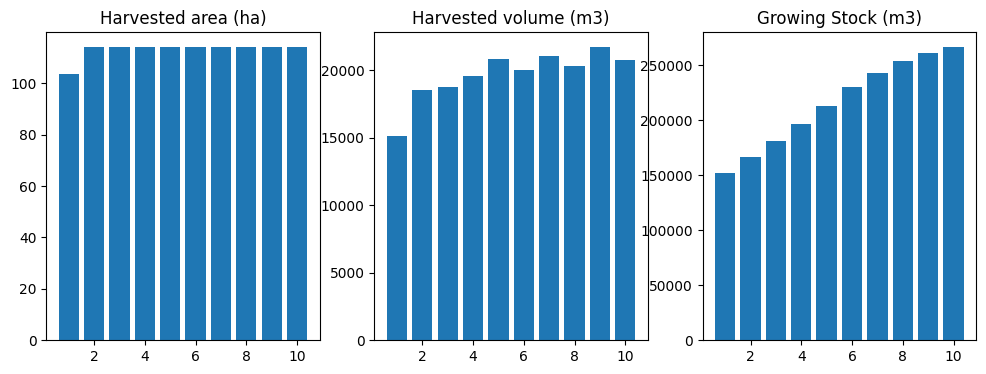

In [97]:
plot_scenario(compile_scenario(fm))